# preparations

## install Qiskit

In [1]:
%pip install qiskit qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.6 MB/s eta 0:00:00


## loading necessary libraries

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, ParameterVector
from qiskit.compiler import transpile
from qiskit import execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix, Operator

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Grover parameter optimizers

In [3]:
# L, x must be positive
def Chebyshev(L:  float, x: float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

# delta, Lambda must be in (0, 1)
def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

# Lambda must be in (0, 1)
def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - np.power(delta * Chebyshev(L, Chebyshev(1 / L, 1 / delta) * np.sqrt(1 - Lambda)), 2)

# P, Lambda must be in (0, 1), N must be a positive integer
def GroverParameterOptimizerForProbability(P: float, Lambda: float, N: int):
    step, L, p = np.exp2(- N), 0, 0
    done = False
    while p < P:
        L += 1
        d = step
        l = GroverQueryComplexity(d, Lambda)
        while l > L:
            d += step
            l = GroverQueryComplexity(d, Lambda)
        delta = d
        while d < 1:
            p_new = GroverProbability(d, Lambda)
            if p_new >= p:
                p, delta = p_new, d
            d += step
            l = GroverQueryComplexity(d, Lambda)

    return delta

# test with general QUBO

In [7]:
Q = np.matrix(100 * np.array([[1.300000000000000044e+00,-6.300000000000000044e-01,-3.400000000000000244e-01,-2.999999999999999889e-01,2.200000000000000011e-01,1.000000000000000056e-01,2.999999999999999889e-02,-5.000000000000000000e-01,2.800000000000000266e-01,-8.000000000000000444e-01,-1.000000000000000056e-01],
                [0.000000000000000000e+00,5.100000000000000089e-01,-2.500000000000000000e-01,4.199999999999999845e-01,4.500000000000000111e-01,8.900000000000000133e-01,8.999999999999999667e-02,-8.000000000000000444e-01,-7.399999999999999911e-01,-6.800000000000000488e-01,-2.000000000000000111e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,8.399999999999999689e-01,2.999999999999999889e-02,-2.999999999999999889e-01,5.000000000000000000e-01,-2.200000000000000011e-01,6.999999999999999556e-01,-2.999999999999999889e-01,5.999999999999999778e-01,2.999999999999999889e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,7.500000000000000000e-01,5.100000000000000089e-01,-2.000000000000000111e-01,2.500000000000000000e-01,2.999999999999999889e-01,-2.999999999999999889e-02,2.999999999999999889e-02,4.000000000000000222e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.700000000000000178e-01,-6.500000000000000222e-01,-4.000000000000000222e-01,2.000000000000000111e-01,-4.600000000000000200e-01,5.400000000000000355e-01,-2.000000000000000111e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,1.499999999999999944e-01,-9.499999999999999556e-01,5.100000000000000089e-01,6.700000000000000400e-01,-2.200000000000000011e-01,-4.000000000000000222e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,3.499999999999999778e-01,-5.999999999999999778e-01,6.300000000000000044e-01,2.000000000000000111e-01,2.500000000000000000e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.500000000000000000e-01,-8.100000000000000533e-01,-5.899999999999999689e-01,-4.000000000000000222e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,5.000000000000000000e-01,1.000000000000000021e-02,2.999999999999999889e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,5.999999999999999778e-01,-1.000000000000000056e-01],
                [0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000056e-01]]), dtype=int)

Q.view()

matrix([[130, -63, -34, -30,  22,  10,   3, -50,  28, -80, -10],
        [  0,  51, -25,  42,  45,  89,   9, -80, -74, -68, -20],
        [  0,   0,  84,   3, -30,  50, -22,  70, -30,  60,  30],
        [  0,   0,   0,  75,  51, -20,  25,  30,  -3,   3,  40],
        [  0,   0,   0,   0,  27, -65, -40,  20, -46,  54, -20],
        [  0,   0,   0,   0,   0,  15, -95,  51,  67, -22, -40],
        [  0,   0,   0,   0,   0,   0,  35, -60,  63,  20,  25],
        [  0,   0,   0,   0,   0,   0,   0,  25, -81, -59, -40],
        [  0,   0,   0,   0,   0,   0,   0,   0,  50,   1,  30],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  60, -10],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10]])

In [ ]:
values = np.empty(1 << len(Q), dtype=int)
for x, _ in enumerate(values):
    conf = (x >> np.arange(len(Q)))&1
    values[x] = conf@Q@conf.T
MaxValue, MinValue = max(values), min(values)
MaxConfig = np.array([(np.where(values == MaxValue)[0][0] >> np.arange(len(Q)))&1])
RandomChance = {val: np.sum(np.where(values == val, 1, 0)) * np.exp2(- len(Q)) for val in np.unique(values)}

spectrum = np.linalg.eigvalsh((Q + Q.T) / 2)
digits = int(np.ceil(np.log2((spectrum[-1] - spectrum[0]) * len(Q)))) + 1

# parallelization prep
entries, blocks = list(np.argwhere(Q - Q.diagonal().diagonal())) + list(np.argwhere(Q.diagonal().diagonal())), []
while entries != []:
    block, qubits, next = [], set(), 0
    while next < len(entries) and len(block) <= digits:
        if entries[next][0] not in qubits and entries[next][1] not in qubits:
            qubits.add(entries[next][0])
            qubits.add(entries[next][1])
            block.append(entries.pop(next))
        else:
            next += 1
    blocks.append(block)

<BarContainer object of 564 artists>

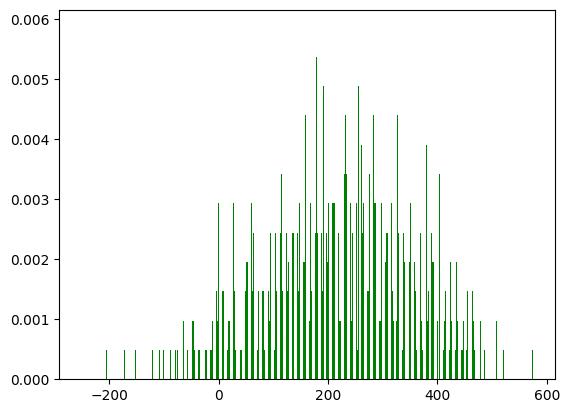

In [ ]:
plt.bar(RandomChance.keys(),
        RandomChance.values(),
        width=0.5,
        color="green")

In [ ]:
powersoftwo = np.array([1 << i for i in range(len(Q))])

MaxSteps, Lambda = 10, 1/2
result = np.random.randint(1 << len(Q))
conf = (result >> np.arange(len(Q)))&1
threshold = values[result]

steps = 0
progress = (threshold - MinValue) / (MaxValue - MinValue)

print(f"configuration\t= {conf}\nthreshold\t= {threshold}\nLambda\t\t= {Lambda}\nprogress\t= {progress:.2%}\nsteps left\t= {MaxSteps - steps}\n")

while steps < MaxSteps:
    delta = GroverParameterOptimizerForProbability(0.9, Lambda, 10)
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    gamma = 1 / np.tanh(np.arccosh(1 / delta) / (2 * l + 1))
    GroverPhases = 2 * np.arctan2(gamma, np.tan(np.arange(1, l + 1) * 2 * np.pi / (2 * l + 1)))

    # circuit preparation
    QRegX = QuantumRegister(len(Q), "x") # quantum registers for the bit configurations
    QControl, QTarget = QRegX[:-1], QRegX[-1] # this is just to make the multi-controlled phase gate's code a bit less confusing
    QRegY = AncillaRegister(digits, "y") # quantum registers to digitize values
    ClRegX = ClassicalRegister(len(Q), "cl")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    # state-preparation
    QC.h(QRegX[:] + QRegY[:])

    # adding threshold - 1
    for i, q in enumerate(reversed(QRegY)):
        QC.rz((threshold - 1) * np.exp2(- i) * np.pi, q)

    # Grover FPS bang-bangs
    for alpha, beta in zip(GroverPhases, reversed(GroverPhases)):

        # S_t (beta)

        for block in blocks:
            for [i, j] in block:
                if i != j:
                    QC.cx(QRegX[i], QRegX[j])

            for d in range(digits):
                for idx, [i, j] in enumerate(block):
                    pos = (d + idx)%digits
                    QC.cp(Q[i, j] * np.exp2(- pos) * np.pi, QRegX[j], QRegY[- 1 - pos])

            for [i, j] in block:
                if i != j:
                    QC.cx(i, j)

        # inverse QFT without the SWAPs
        for i, q in enumerate(reversed(QRegY)):
            QC.h(q)
            for j, r in enumerate(reversed(QRegY[:- i - 1])):
                QC.cp(- np.pi * np.exp2(- (j + 1)), q, r)

        QC.rz(beta, QRegY[0])

        # QFT without the SWAPs
        for i, q in enumerate(QRegY):
            QC.h(q)
            for j, r in enumerate(QRegY[i + 1:]):
                QC.cp(np.pi * np.exp2(- (j + 1)), q, r)

        for block in blocks:
            for [i, j] in block:
                if i != j:
                    QC.cx(QRegX[i], QRegX[j])

            for d in range(digits):
                for idx, [i, j] in enumerate(block):
                    pos = (d + idx)%digits
                    QC.cp(- Q[i, j] * np.exp2(- pos) * np.pi, QRegX[j], QRegY[- 1 - pos])

            for [i, j] in block:
                if i != j:
                    QC.cx(i, j)

        # S_s (alpha) / this implementation is only better when len(QuadraticForm) > 4
        QC.h(QRegX)
        QC.x(QRegX)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(np.pi * np.exp2(- (j + 1)), q, p)
            QC.cp(alpha * np.exp2(- (i + 1)), q, QTarget)

        for i, q in enumerate(QControl[1:]):
            QC.crx(np.pi * np.exp2(- i), QControl[0], q)
            QC.cp(- alpha * np.exp2(i + 1 - len(QControl)), q, QTarget)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- np.pi * np.exp2(- (j + 1)), q, p)

        QC.cp(alpha * np.exp2(1 - len(QControl)), QControl[0], QTarget)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(np.pi * np.exp2(- (j + 1)), q, p)

        for i, q in enumerate(QControl[1:]):
            QC.crx(- np.pi * np.exp2(- i), QControl[0], q)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- np.pi * np.exp2(- (j + 1)), q, p)

        QC.x(QRegX)
        QC.h(QRegX)

    QC.measure(QRegX, ClRegX)

    simulator = AerSimulator()
    QC = transpile(circuits=QC,
                   backend=simulator)

    preconf = [1 if bit == "1" else 0 for bit in reversed(list(execute(QC, simulator, shots = 1).result().get_counts().keys())[0])]
    result = np.dot(preconf, powersoftwo)

    if values[result] > threshold:
        conf = preconf
        threshold = values[result]
        progress = (threshold - MinValue) / (MaxValue - MinValue)
    else:
        Lambda /= 2

    steps += l

    print(f"configuration\t= {conf}\nthreshold\t= {threshold}\nLambda\t\t= {Lambda}\nprogress\t= {progress:.2%}\nsteps left\t= {MaxSteps - steps}\n")

print("done")

configuration	= [1 0 1 0 0 0 0 0 1 0 0]
threshold	= 228
Lambda		= 0.5
progress	= 58.01%
steps left	= 10

configuration	= [1 0 1 0 0 0 0 0 1 0 0]
threshold	= 228
Lambda		= 0.25
progress	= 58.01%
steps left	= 9

configuration	= [1 0 1 0 0 0 0 0 1 0 0]
threshold	= 228
Lambda		= 0.125
progress	= 58.01%
steps left	= 8

configuration	= [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]
threshold	= 352
Lambda		= 0.125
progress	= 73.06%
steps left	= 6

configuration	= [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]
threshold	= 352
Lambda		= 0.0625
progress	= 73.06%
steps left	= 4

configuration	= [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
threshold	= 403
Lambda		= 0.0625
progress	= 79.25%
steps left	= 1

configuration	= [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
threshold	= 403
Lambda		= 0.03125
progress	= 79.25%
steps left	= -2

done


In [ ]:
delta = GroverParameterOptimizerForProbability(0.9, 0.0625, 10)
l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - 0.0625)))) // 2
l

3